# Bibliotecas

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Variáveis globais

In [79]:
global goalPos

# Modelos cinemáticos

## Funções auxiliares

In [80]:
def calcularErros(robotState):
    xg, yg = goalPos

    x, y, theta = robotState
    
    #Erro de posição
    e = np.sqrt((xg - x) ** 2 + (yg - y) ** 2)

    phi = np.arctan2(yg - y, xg - x)

    #Erro de orientação
    alpha = phi - theta
    alpha = np.arctan2(np.sin(alpha), np.cos(alpha))  # Normalize angle to [-pi, pi]

    return e, alpha

def calcularVarControle(robotState, ref, ganhos):

    x, y, theta = robotState
    e, alpha = calcularErros(robotState)

    if ref == 'Aicardi':
        gamma, k, h = ganhos

        v = gamma*e*np.cos(alpha)
        omega = k*alpha + (v/(e*alpha))*np.sin(alpha)*(alpha + h*(alpha + theta))

    elif ref == 'Karim':
        Kv, Kw = ganhos

        v = Kv*e*np.cos(alpha)
        omega = Kw*alpha + (v/e)*np.sin(alpha)
    
    else:
        tau, kappa = ganhos

        v = tau*e*np.cos(alpha)
        omega = kappa*alpha + (v/e)*np.sin(alpha)
    
    return v, omega


## Modelos Cinemáticos

In [81]:
def cinematicModel(t, state, modo, ganhos):
    x, y, theta = state
    v, omega = calcularVarControle(state, ref=modo, ganhos=ganhos)

    #Avanço temporal do modelo
    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = omega

    return [dx, dy, dtheta]


## Evento de parada da simulação

In [82]:
def stopEvent(t, state, modo, ganhos):
    e, alpha = calcularErros(state)
    return e - 0.01

stopEvent.terminal = True
stopEvent.direction = -1

# Simulação

## Parâmetros padrão da simulação

In [83]:
t_span = (0, 50)  # Time span for the simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points to evaluate

x0 = [0, 0, np.pi/2]  # Initial state: [x, y, theta]
goalPos = [1, 0]

## Resultados

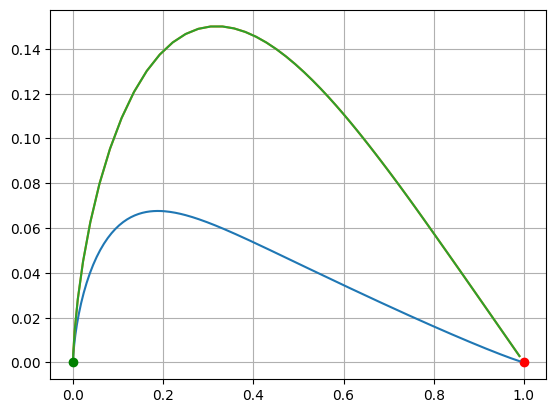

In [84]:
solutions = {}
for autor in ['Aicardi', 'Karim', 'Breno']:
    if autor == 'Aicardi':
        ganhos = [0.1, 1, 1]
    else:
        ganhos = [0.7777, 2.555]

    solutions[autor] = solve_ivp(cinematicModel, t_span=t_span, t_eval=t_eval, y0=x0, method='RK45', events=stopEvent, args=(autor, ganhos))


plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position

for key in solutions.keys():
    x, y = solutions[key].y[:2]
    plt.plot(x, y)

plt.plot(x[0], y[0], 'go')
plt.grid()

# Ortimização dos parâmetros

## Referências

In [85]:
from SGA import *

x0 = [0, 0, np.pi/2]
goalPos = [1, 0]

y_ref = 0.15
v_ref = 1.2
w_ref = 300*np.pi/180

# Função para converter binário -> valor real
def bin_to_real(pop_bin, x_min=0, x_max=4):
    """Converte população binária em valores reais de x"""

    num_bits = len(pop_bin)
    resolucao = (x_max - x_min) / (2**num_bits - 1)

    valores_decimais = pop_bin.dot(2 ** np.arange(num_bits)[::-1])
    return x_min + valores_decimais * resolucao

## Fitnesses Functions

In [86]:
def fitness_function_b(pop):

    fitness_value = []
    for ind in pop:
        tau   = bin_to_real(ind[:int(0.5*len(ind))])
        kappa = bin_to_real(ind[int(0.5*len(ind)):])

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau, kappa]))
        x, y, theta = sol.y
        v, w = calcularVarControle(sol.y, 'Breno', [tau, kappa])

        F = 1/np.abs(np.max(np.abs(y)) - y_ref) + 1/np.abs(np.max(np.abs(v)) - v_ref)

        fitness_value.append(F)

    return fitness_value

def fitness_function_k(pop):

    fitness_value = []
    
    for ind in pop:
        Kv = bin_to_real(ind[:int(0.5*len(ind))])
        Kw = bin_to_real(ind[int(0.5*len(ind)):])

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv, Kw]))
        e, alpha = calcularErros(sol.y)
        v, w = calcularVarControle(sol.y, 'Karim', [Kv, Kw])

        J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)
        F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

        fitness_value.append(F - J)
    
    return fitness_value

def fitness_function_a(pop):

    fitness_values = []
    for ind in pop:
        gamma  = bin_to_real(ind[:int(1/3*len(ind))], 0, 4)
        k      = bin_to_real(ind[int(1/3*len(ind)):int(2/3*len(ind))], 0, 4)
        h      = bin_to_real(ind[int(2/3*len(ind)):], 0, 4)

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [gamma, k, h]))
        v, w = calcularVarControle(sol.y, 'Karim', [gamma, k, h])

        F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

        fitness_values.append(F)

    return fitness_values

## Costs Functions

In [87]:
def cost_function_b(params):

    tau, kappa = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau, kappa]))
    x, y, theta = sol.y
    v, w = calcularVarControle(sol.y, 'Breno', [tau, kappa])

    F = 1/np.abs(np.max(np.abs(y)) - y_ref) + 1/np.abs(np.max(np.abs(v)) - v_ref)

    return 1/F

def cost_function_k(params):
    Kv, Kw = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv, Kw]))
    e, alpha = calcularErros(sol.y)
    v, w = calcularVarControle(sol.y, 'Karim', [Kv, Kw])

    J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)
    F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

    return -(F - J)

def cost_function_a(params):

    gamma, k, h = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [gamma, k, h]))
    v, w = calcularVarControle(sol.y, 'Karim', [gamma, k, h])

    F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

    return -F



## Breno

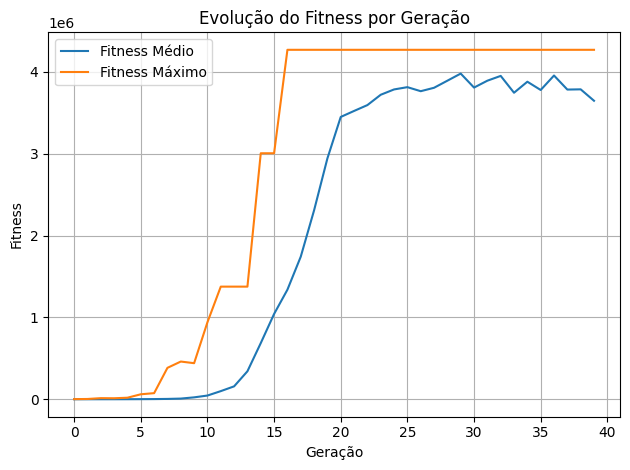

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.0654949972167843e-11
            Iterations: 5
            Function evaluations: 31
            Gradient evaluations: 5


,SpeedyGA,FMinCom
Tau,1.078610,0.304326
Kappa,3.547123,1.000976
Max y,0.150000,0.150000
Max v,0.828360,0.233844
Max w,319.241027,90.087879


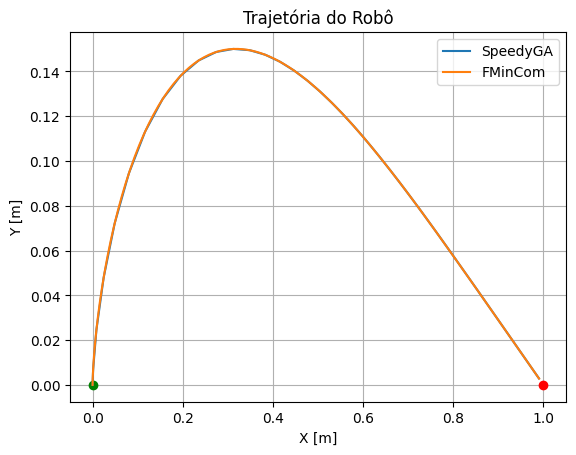

In [88]:
"""### SpeedyGA ###"""
best = evolve(fitnessFunction=fitness_function_b, length=40, popSize=200, maxGens=40, probMutation=0.003, probCrossover=1)

tau_best   = bin_to_real(best[:int(0.5*len(best))])
kappa_best = bin_to_real(best[int(0.5*len(best)):])

sol_sga = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau_best, kappa_best]))
x, y, theta = sol_sga.y
v, w = calcularVarControle(sol_sga.y, 'Breno', [tau_best, kappa_best])

speedyGA_results = [tau_best, kappa_best, max(np.abs(y)), max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### FMinCom ###"""
controlVar_guess_b = [0.1, 1]  # Initial guess for tau and kappa
bounds = [(0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_b, controlVar_guess_b, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

tau_best = result.x[0]
kappa_best = result.x[1]

sol_fmc = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau_best, kappa_best]))
x, y, theta = sol_fmc.y
v, w = calcularVarControle(sol_fmc.y, 'Breno', [tau_best, kappa_best])

fmincom_results = [tau_best, kappa_best, max(np.abs(y)), max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### Resultados ###"""
res = pd.DataFrame({
    'SpeedyGA': speedyGA_results,
    'FMinCom': fmincom_results
}, index=['Tau', 'Kappa', 'Max y', 'Max v', 'Max w'])

display(res)

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x[0], y[0], 'go')  # Plot goal position
plt.plot(sol_sga.y[0], sol_sga.y[1], label='SpeedyGA')
plt.plot(sol_fmc.y[0], sol_fmc.y[1], label='FMinCom')
plt.legend()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Trajetória do Robô')
plt.grid()

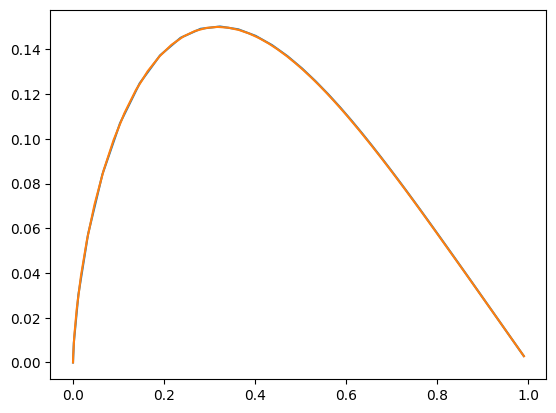

In [63]:
plt.plot(sol_fmc.y[0], sol_fmc.y[1])
plt.plot(sol_sga.y[0], sol_sga.y[1])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -125175.09033973604
            Iterations: 12
            Function evaluations: 65
            Gradient evaluations: 10
Melhor tau: 1.0807
Melhor kappa: 3.9559

Max(y) = 0.1400
Max(v) = 0.8426
Max(w) = 356.0274°/s


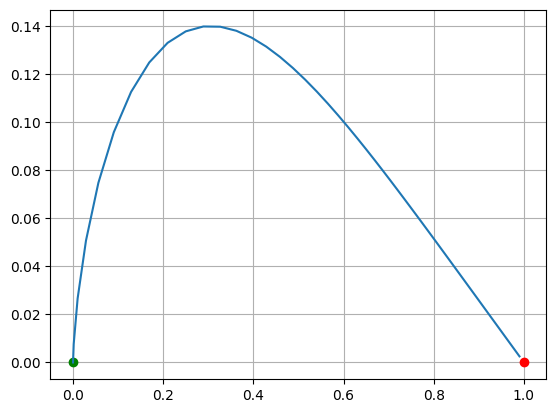

In [15]:
x0 = [0, 0, np.pi/2]  # Reset initial state 
goalPos = [1, 0]  # Reset goal position

y_ref = 0.14
v_ref = 1.1

def cost_function_b(params):
    global tau, kappa

    tau, kappa = params

    sol_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_b, y_b, phi_b, e_b, alpha_b, v_b, omega_b = calculoVariaveis_Breno(sol_b.y)

    y_max = np.max(y_b)
    v_max = np.max(v_b)

    Phi_y = np.abs(y_max - y_ref)
    Phi_v = np.abs(v_max - v_ref)

    F = 1/Phi_y + 1/Phi_v

    return -F

controlVar_guess_b = [0.1, 1]  # Initial guess for tau and kappa
bounds = [(0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_b, controlVar_guess_b, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

tau_best, kappa_best = result.x

print(f"Melhor tau: {tau_best:.4f}")
print(f"Melhor kappa: {kappa_best:.4f}")

global tau, kappa
tau, kappa = tau_best, kappa_best

sol_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_b, y_b, phi_b, e_b, alpha_b, v_b, w_b = calculoVariaveis_Breno(sol_b.y)

print()
print(f'Max(y) = {np.max(y_b):.4f}')
print(f'Max(v) = {np.max(v_b):.4f}')
print(f'Max(w) = {np.max(np.abs(w_b*180/np.pi)):.4f}°/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_b[0], y_b[0], 'go')  # Plot goal
plt.plot(x_b, y_b)
plt.grid()


## Karim

### SpeedGA

gen = 000   avgFitness = 11.353  maxFitness = 196.739
gen = 001   avgFitness = 59.769  maxFitness = 4230.232
gen = 002   avgFitness = 13.612  maxFitness = 322.812
gen = 003   avgFitness = 20.949  maxFitness = 612.150
gen = 004   avgFitness = 25.842  maxFitness = 860.897
gen = 005   avgFitness = 18.300  maxFitness = 198.229
gen = 006   avgFitness = 32.539  maxFitness = 1056.317
gen = 007   avgFitness = 82.490  maxFitness = 2376.157
gen = 008   avgFitness = 91.589  maxFitness = 2049.489
gen = 009   avgFitness = 121.904  maxFitness = 2128.227
gen = 010   avgFitness = 186.239  maxFitness = 2721.657
gen = 011   avgFitness = 392.335  maxFitness = 5658.736
gen = 012   avgFitness = 1975.959  maxFitness = 111261.607
gen = 013   avgFitness = 3744.931  maxFitness = 111261.607
gen = 014   avgFitness = 1769.219  maxFitness = 66756.651
gen = 015   avgFitness = 4510.714  maxFitness = 111262.479
gen = 016   avgFitness = 11612.177  maxFitness = 333775.831
gen = 017   avgFitness = 8296.232  maxFitness =

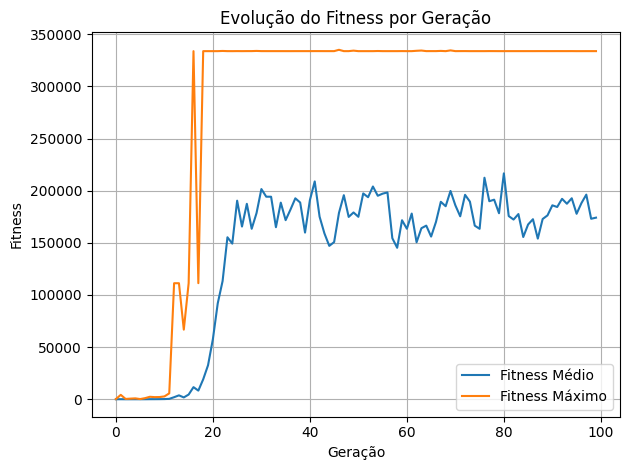

Melhor Kv: 1.5293
Melhor Kw: 3.3333

Max(v) = 1.0992 m/s
Max(w) = 299.9998 °/s


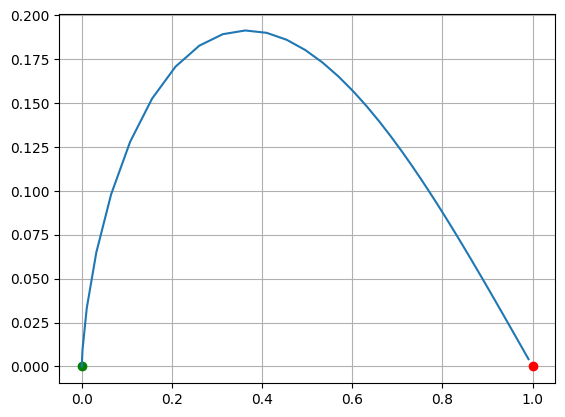

In [17]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

# Função de fitness
def fitness_function_k(pop):
    global Kv, Kw

    fitness_values = []

    for ind in pop:
        Kv  = bin_to_real(ind[:int(0.5*len(ind))], 0, 4)
        Kw  = bin_to_real(ind[int(0.5*len(ind)):], 0, 4)

        sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
        x_k, y_k, theta_k, eD_k, alpha_k, v_k, w_k = calculoVariaveis_Karim(sol_k.y)

        J = 0.5*np.trapz((eD_k/eD_k[0])**2 + (alpha_k/alpha_k[0])**2, sol_k.t)
        F = 1/(np.abs(np.max(v_k) - v_ref)) + 1/(np.abs(np.max(np.abs(w_k)) - w_ref))

        fitness_values.append(1/J + F)

    return fitness_values


best = evolve(
    fitnessFunction=fitness_function_k,
    length=40,
    popSize=100,
    maxGens=100,
    probMutation=0.03,
    probCrossover=1
)

half = int(0.5 * len(best))
Kv_best   = bin_to_real(best[:half], 0, 4)
Kw_best = bin_to_real(best[half:], 0, 4)

print(f"Melhor Kv: {Kv_best:.4f}")
print(f"Melhor Kw: {Kw_best:.4f}")

Kv = Kv_best
Kw = Kw_best

sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

print()
print(f'Max(v) = {np.max(v_k):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(omega_k*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_k[0], y_k[0], 'go')  # Plot goal position
plt.plot(x_k, y_k)
plt.grid()


### fmincon

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3598246.806476152
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Melhor Kv: 1.9829
Melhor Kw: 1.2037

Max(v) = 1.1000 m/s
Max(w) = 121.7738 °/s


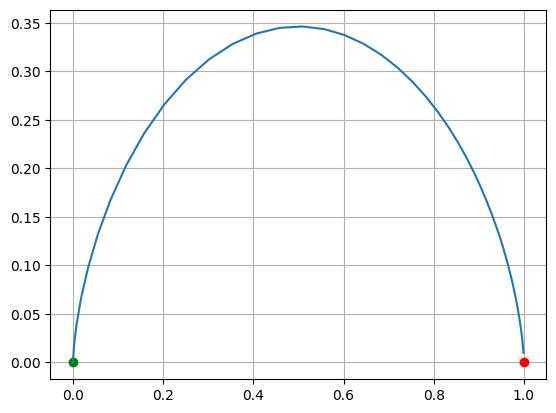

In [19]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

def cost_function_k(params):
    global Kv, Kw

    Kv, Kw = params

    sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

    J = 0.5*np.trapz((eD_k/eD_k[0])**2 + (alpha_k/alpha_k[0])**2, sol_k.t)
    F = 1/(np.abs(np.max(v_k) - v_ref)) + 1/(np.abs(np.max(np.abs(omega_k)) - w_ref))

    return J - F

controlVar_guess_k = [0.1, 1]  # Initial guess for Kv and Kw
bounds = [(0, 4), (0, 4)]  # Bounds for Kv

result = minimize(cost_function_k, controlVar_guess_k, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

Kv_best, Kw_best = result.x

print(f"Melhor Kv: {Kv_best:.4f}")
print(f"Melhor Kw: {Kw_best:.4f}")

global Kv, Kw
Kv, Kw = Kv_best, Kw_best

sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

print()
print(f'Max(v) = {np.max(v_k):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(omega_k*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_k[0], y_k[0], 'go')  # Plot goal
plt.plot(x_k, y_k)
plt.grid()

## Aicardi

### SpeedyGA

gen = 000   avgFitness = 9.673  maxFitness = 683.307
gen = 001   avgFitness = 11.962  maxFitness = 850.459
gen = 002   avgFitness = 21.352  maxFitness = 1749.757
gen = 003   avgFitness = 16.922  maxFitness = 910.821
gen = 004   avgFitness = 32.510  maxFitness = 2025.615
gen = 005   avgFitness = 29.192  maxFitness = 2025.615
gen = 006   avgFitness = 25.395  maxFitness = 1129.747
gen = 007   avgFitness = 35.706  maxFitness = 2241.103
gen = 008   avgFitness = 33.054  maxFitness = 2244.116
gen = 009   avgFitness = 41.855  maxFitness = 2246.183
gen = 010   avgFitness = 126.686  maxFitness = 12365.692
gen = 011   avgFitness = 267.640  maxFitness = 30346.519
gen = 012   avgFitness = 147.983  maxFitness = 9540.072
gen = 013   avgFitness = 2069.835  maxFitness = 333776.074
gen = 014   avgFitness = 746.238  maxFitness = 37086.788
gen = 015   avgFitness = 347.449  maxFitness = 25675.924
gen = 016   avgFitness = 1037.773  maxFitness = 47690.976
gen = 017   avgFitness = 2326.156  maxFitness = 11128

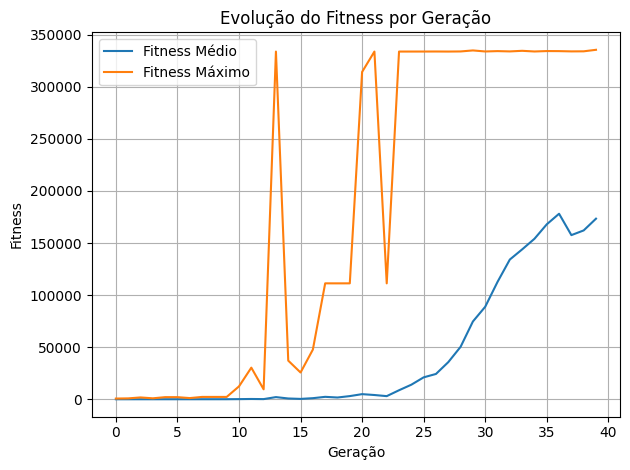

Melhor gamma: 1.5286
Melhor k: 3.3333
Melhor h: 0.1778

Max(v) = 1.1006 m/s
Max(omega) = 300.0002°/s


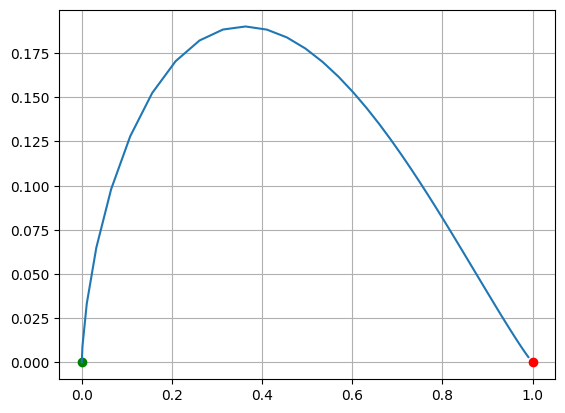

In [20]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

def fitness_function_a(pop):
    global gamma, k, h

    fitness_values = []

    for ind in pop:
        gamma  = bin_to_real(ind[:int(1/3*len(ind))], 0, 4)
        k      = bin_to_real(ind[int(1/3*len(ind)):int(2/3*len(ind))], 0, 4)
        h      = bin_to_real(ind[int(2/3*len(ind)):], 0, 4)

        sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
        x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

        F = 1/(np.abs(np.max(v_a) - v_ref)) + 1/(np.abs(np.max(np.abs(w_a)) - w_ref))

        fitness_values.append(F)

    return fitness_values

best = evolve(
    fitnessFunction=fitness_function_a,
    length=60,
    popSize=200,
    maxGens=40,
    probMutation=0.03,
    probCrossover=1
)

gamma_best   = bin_to_real(best[:int(1/3*len(best))], 0, 4)
k_best       = bin_to_real(best[int(1/3*len(best)):int(2/3*len(best))], 0, 4)
h_best       = bin_to_real(best[int(2/3*len(best)):], 0, 4)

print(f"Melhor gamma: {gamma_best:.4f}")
print(f"Melhor k: {k_best:.4f}")
print(f"Melhor h: {h_best:.4f}")

gamma = gamma_best
k = k_best 
h = h_best

sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_a, y_a, phi_a, e_a, alpha_a, v_a, omega_a = calculoVariaveis_Aicardi(sol_a.y)

print()
print(f'Max(v) = {np.max(v_a):.4f} m/s')
print(f'Max(omega) = {np.max(np.abs(omega_a*180/np.pi)):.4f}°/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal position
plt.plot(x_a, y_a) 
plt.grid()

### fmincon

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -101477.09499906024
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 10
Melhor gamma: 3.9045
Melhor k: 2.2555
Melhor h: 1.5113

Max(v) = 2.3297 m/s
Max(w) = 300.0006 °/s


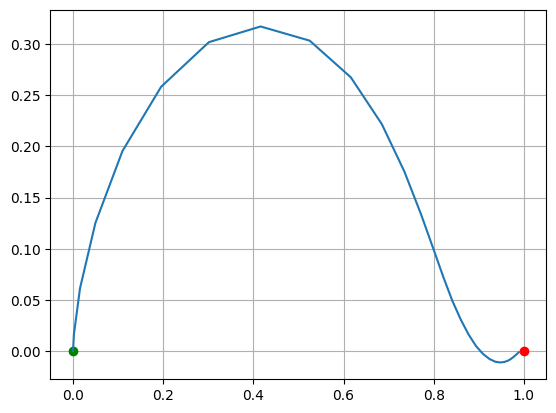

In [23]:
x0 = [0, 0, np.pi/2]  # Reset initial state 
goalPos = [1, 0]  # Reset goal position

v_ref = 1.1
w_ref = 300*np.pi/180

def cost_function_a(params):
    global gamma, k, h

    gamma, k, h = params

    sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

    F =  1/np.abs(np.max(v_a) - v_ref) +1/np.abs(np.max(np.abs(w_a)) - w_ref)
    
    return -F

controlVar_guess_a = [0.1, 1, 1]  # Initial guess for gamma, k, h
bounds = [(0, 4), (0, 4), (0, 4)]  # Bounds for gamma, k, h

result = minimize(cost_function_a, controlVar_guess_a, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

gamma_best, k_best, h_best = result.x

print(f"Melhor gamma: {gamma_best:.4f}")
print(f"Melhor k: {k_best:.4f}")
print(f"Melhor h: {h_best:.4f}")

global gamma, k, h
gamma, k, h = gamma_best, k_best, h_best

sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

print()
print(f'Max(v) = {np.max(v_a):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(w_a*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal
plt.plot(x_a, y_a)
plt.grid()